# Importing packages

In [284]:
# Importing, cleaning and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Model Validation
from sklearn.model_selection import train_test_split
# Imputation
from sklearn.impute import KNNImputer
# Model Evaluation
from sklearn.metrics import confusion_matrix,plot_roc_curve,accuracy_score,recall_score, precision_score,plot_confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
# Balancing
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# Scaling data
from sklearn.preprocessing import StandardScaler
# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Feature selection
from boruta import BorutaPy
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [285]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


#### Functions

In [286]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    """
    Function to remove columns with missing data that exceed the set percentage threshold limit
    
    Required arguments - 
    dataframe - Dataframe for processing (type-Pandas Dataframe)
    threshold - threshold above which columns will be removed (type-float)
    
    Optional arguments - None
    
    Expected output - Message with threshold value and number of columns removed
                      Pandas Dataframe that does not contain columns with more missing values than the threshold value
    
    """
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [287]:
def replace_outlier(val, mean, std):
    """
    Function to check if a number is greater/lower than (mean +/- 3*standard deviation) 
    and replace that number with (mean +/- 3*standard deviation)
    
    Required arguments - 
    val - any value - float
    mean - mean of values - float
    std - standard deviation of values - float
        
    Optional arguments - None
    
    Expected output - If value is lower than (mean - 3*standard deviation) then return value
                      If value is higher than (mean + 3*standard deviation) then return (mean + 3*standard deviation)    
    """
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [288]:
def evaluate(model, X_train,X_test,y_train,y_test):
    """
    Function to fit any model to the training dataset and evaluate that model using test dataset using confusion matrix, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training dataset without the target variable
    X_test - test dataset without the target variabl
    y_train - training dataset of the target variable
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters, Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of Confusion Matrix and AUC
    
    """
    figure(figsize=(8, 5), dpi=80)
    model.fit(X_train, y_train)
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    y_pred = model.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
    ax = plt.gca()
    plot = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    print("Model Name:", model)
    f1score = f1_score(y_test, y_pred, average='micro')
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    print("F1 Score:", f1score) 
    print("Sensitivity:" , sensitivity)
    print("Recall:" , recall)
    print("Precision:" , precision)

In [289]:
def BorutaFeatureSelection (X_train, y_train) :
    """
    Function to find the best features using Boruta along with the feature scores. Only features with Rank 1 will 
    be selected and tentative features will be ignored.
    
    Required arguments - 
    X_train - training dataset without the target variable
    y_train - training dataset of the target variable
    
    Optional arguments - None
    
    Expected output - Output message - Feature ranking and whether that feature will be kept or removed
                                     - Final features
                      Pandas Dataframe that contains only final features selected using Boruta
    """
    feature_names = np.array(X_train.columns)

    model =RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=6,class_weight='balanced_subsample')
    model.fit(X_train, y_train)
    
    feature_selector = BorutaPy(model, random_state=2, verbose=2,max_iter=455,n_estimators=200)

    feature_selector.fit(X_train.to_numpy(),y_train)

    feature_selector.support_

    feature_selector.ranking_

    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
    return pd.DataFrame(X_train.filter(final_features)) , final_features

In [290]:
def Sampling(X_train, y_train, sampler):
    """
    Function to apply any balancing method to a dataframe
    
    Required arguments - 
    X_train - training dataset without the target variable (pandas dataframe)
    y_train - training dataset of the target variable (pandas dataframe)
    sampler - Name of balancing method (string)
    
    Optional arguments - None
    
    Expected output - Pandas Dataframe with balanced data
    """
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Importing and basic cleaning

In [291]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [292]:
# Assigning data to a Pandas Dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [293]:
# Renaming the columns' headers
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [294]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [295]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [296]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [297]:
# Changing datatype for consistency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [298]:
# Merging data
data= pd.concat([secom_labels,secom_data],axis=1)

In [299]:
# Dropping the Timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [300]:
# Using the Classification column as the target variable
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

# Spliting data into training set and test set

#### We split the data into a ratio of 80:20. Since the dataset is not large enough, we use 80% of the data for training. We will train the model on the training data and evaluate the model on the test data

#### We use the startify parameter because the data is imbalanced between pass and fail and this will ensure the same ratio of pass and fail is retained when spliting the data. The random_state parameter will help us create a reproducible data. 

In [301]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)

# Removing columns with more than 50% of missing values

In [302]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [303]:
# Deleting the same columns that are removed in training set from the test set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Replacing outliers with 3s boundary

In [304]:
#Replacing the outliers with 3s boundaries in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [305]:
# Replacing the outliers with 3s boundaries in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# Imputing the missing values with KNN

In [306]:
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [307]:
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

# Feature Selection using Boruta

In [308]:
X_train_boruta , final_features = BorutaFeatureSelection(X_train_knn,y_train.values.ravel())

Iteration: 	1 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	2 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	3 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	4 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	5 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	6 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	7 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	8 / 455
Confirmed: 	0
Tentative: 	27
Rejected: 	531
Iteration: 	9 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	10 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	11 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	12 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	13 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	14 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	15 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	16 / 455
Confirmed: 	6
Tentat

Iteration: 	127 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	128 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	129 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	130 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	131 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	132 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	133 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	134 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	135 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	136 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	137 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	138 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	139 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	140 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	141 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	252 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	253 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	254 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	255 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	256 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	257 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	258 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	259 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	260 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	261 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	262 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	263 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	264 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	265 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	266 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	377 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	378 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	379 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	380 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	381 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	382 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	383 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	384 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	385 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	386 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	387 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	388 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	389 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	390 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	391 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

In [309]:
# Deleting the columns that are removed in training set from the test set
X_test_boruta = X_test_knn[np.array(X_train_boruta.columns)]
X_test_boruta.shape

(314, 20)

### Checking the correlation between variables

Text(0.5, 1.0, 'Heatmap for the Data')

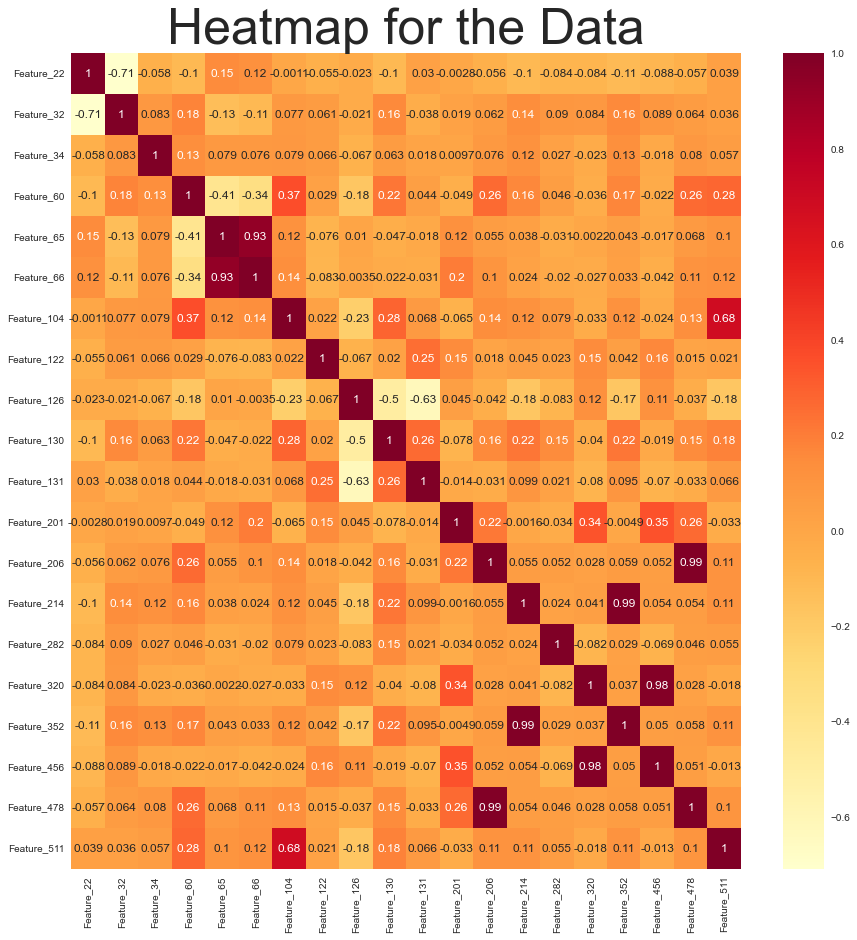

In [310]:
# Correlation Heatmap
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(X_train_boruta.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

### Analysing the best featues

Text(0.5, 0, 'Feature Importance')

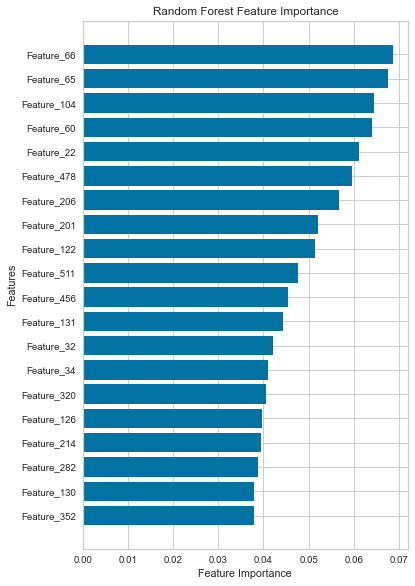

In [323]:
model = RandomForestClassifier()
model.fit(X_train_boruta, y_train.values.ravel())
feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100)
figure(figsize=(6, 10), dpi=70)
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train_boruta.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel("Feature Importance")

# Balancing the data using ROSE

In [324]:
# Balancing data using Random Over-Sampling Examples (ROSE)
X_rose, y_rose = Sampling(X_train_boruta, y_train,'ROSE')

# Scaling the data and fitting the Model
# - Random Forest Classifier

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.8662420382165607
Sensitivity: 0.9630996309963099
Recall: 0.5238095238095238
Precision: 0.2558139534883721


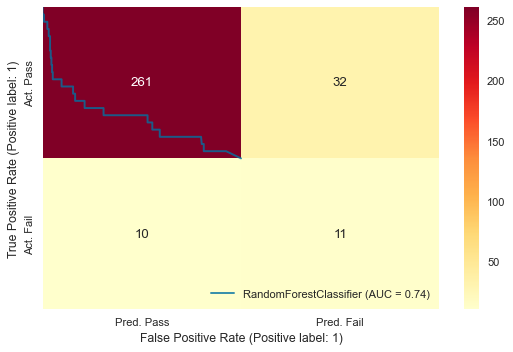

In [325]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_rose,X_test_boruta,y_rose,y_test)

# Tuning the Model

In [326]:
# Random forest 

# Defining the parameters we want to try
params = {'criterion' : ["gini","entropy","log_loss"],
          'max_depth':[4,5,6,7,8,9,10],
         'max_features':["sqrt","log2","auto",None]}
          
# We want the find the best parameters on the basis of the highest AUC
# Fitting the model as per fixed and trial paramters and applying crossvalidation using StratifiedKFold = 10
grid_searcher = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), params,scoring='roc_auc', cv = 10, verbose=1)

# Fitting the best parameters
grid_searcher.fit(X_rose, y_rose)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', 'auto', None]},
             scoring='roc_auc', verbose=1)

In [327]:
#Printing the best estimator

print('\n Best estimator:')
print(grid_searcher.best_estimator_)

# Printing the best parameters
print('\n Best hyperparameters:')
print(grid_searcher.best_params_)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       random_state=42)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}


Model Name: RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       random_state=42)
F1 Score: 0.89171974522293
Sensitivity: 0.9675090252707581
Recall: 0.5714285714285714
Precision: 0.32432432432432434


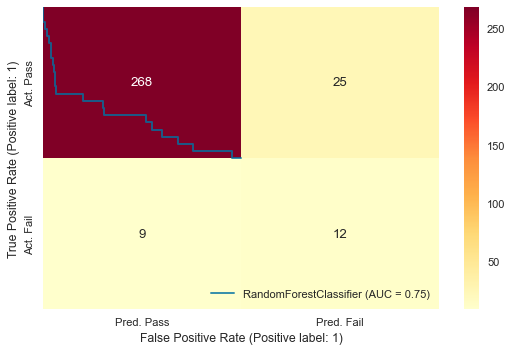

In [328]:
# Fitting the model with the tuned parameters
evaluate(grid_searcher.best_estimator_,X_rose,X_test_boruta,y_rose,y_test)


# Checking if our model is overfitting

In [329]:
# define the tree depth to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
test_scores=[]
train_scores=[]
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators=100,max_features='sqrt',random_state=42,n_jobs=-1,max_depth=i,criterion='entropy')
    # fit model on the training dataset
    model.fit(X_rose, y_rose)
    # evaluate on the training dataset
    train_yhat = model.predict(X_rose)
    train_acc = accuracy_score(y_rose, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test_boruta)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('%d train: %.3f, test: %.3f' % (i, train_acc, test_acc))

1 train: 0.768, test: 0.799
2 train: 0.798, test: 0.793
3 train: 0.818, test: 0.815
4 train: 0.843, test: 0.806
5 train: 0.888, test: 0.847
6 train: 0.921, test: 0.854
7 train: 0.947, test: 0.879
8 train: 0.964, test: 0.892
9 train: 0.975, test: 0.892
10 train: 0.978, test: 0.892
11 train: 0.985, test: 0.892
12 train: 0.987, test: 0.882
13 train: 0.988, test: 0.895
14 train: 0.990, test: 0.885
15 train: 0.993, test: 0.882
16 train: 0.995, test: 0.892
17 train: 0.996, test: 0.885
18 train: 0.997, test: 0.885
19 train: 0.998, test: 0.889
20 train: 0.999, test: 0.885


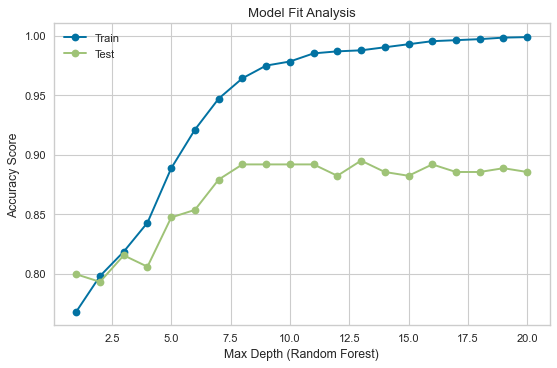

In [330]:
# Plotting the results to have a better view
figure(figsize=(8, 5), dpi=80)
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
plt.title('Model Fit Analysis')
plt.xlabel('Max Depth (Random Forest)')
plt.ylabel('Accuracy Score')
pyplot.legend()
pyplot.show()

In [331]:
# Evaluation using Startified K-Fold cross-validation
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(grid_searcher.best_estimator_, X_rose, y_rose, cv=cv, scoring = 'roc_auc')
print(scores)
print("Mean of Scores :",scores.mean())

[0.85009862 0.97523559 0.97582    0.98853094 0.98853094 0.98232157
 0.98151801 0.99196435 0.96617722 0.97560085]
Mean of Scores : 0.9675798086054497


# Final Model after considering best fit

Model Name: RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=-1,
                       random_state=42)
F1 Score: 0.89171974522293
Sensitivity: 0.96415770609319
Recall: 0.5238095238095238
Precision: 0.3142857142857143


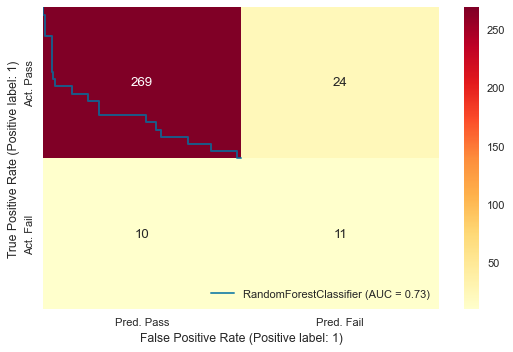

In [332]:
evaluate(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,max_depth=8,criterion='entropy',max_features='sqrt'),
         X_rose,X_test_boruta,y_rose,y_test)

